<div style="background: linear-gradient(135deg, #034694 0%, #1E8449 50%, #D4AC0D 100%); color: white; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.2);">
    <h1 style="color: #FFF; text-shadow: 1px 1px 3px rgba(0,0,0,0.5);">💬 | Step 3: Be More Cost-Effective With Distillation </h1>
        <p style="font-size: 16px; line-height: 1.6;">
            We have the model customized to provide the right tone and style. But we are using a large (slow and expensive) model for a very narrow and focused task. Let's see how we can distill the knowledge to a smaller (faster and cheaper) model to get comparable accuracy with better efficiency - by trading in general-purpose LLMs for a narrower task-specific intelligence.
        </p>
</div>

<div style="display: flex; align-items: center; justify-content: left; padding: 5px; height: 40px; background: linear-gradient(90deg, #333333 0%, #777777 50%, #BBBBBB 100%); border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.12); font-size: 1.5em; font-weight: bold; color: #fff;">
    Step 1 : Understand Zava Scenarios
</div>
<br/>
<div style="display: flex; align-items: center; justify-content: left; padding: 5px; height: 40px; background: linear-gradient(90deg, #333333 0%, #777777 50%, #BBBBBB 100%); border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.12); font-size: 1.5em; font-weight: bold; color: #fff;">
    Step 2 : Be More Helpful With SFT
</div>
<br/>

---

## 1. Check Environment Setup



In [1]:
# First, make sure required environment variables are set
import os

openai_key = os.getenv("AZURE_OPENAI_API_KEY")
openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model_name = "gpt-4.1"
api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2025-02-01-preview")

if not openai_key or not openai_endpoint:
    print("Error: Missing AZURE_OPENAI_KEY or AZURE_OPENAI_ENDPOINT environment variable.")

print("Using Model:", model_name)
print("Using API Version:", api_version)

Using Model: gpt-4.1
Using API Version: 2025-02-01-preview


In [2]:
# Then create an Azure OpenAI Client instance
from openai import AzureOpenAI

client = AzureOpenAI(
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
    api_key=os.environ.get("AZURE_OPENAI_API_KEY"),
    api_version="2025-04-01-preview",
)

In [3]:
# And create a handy UUID we can use to track each run of this notebook
import uuid
UNIQUE_ENOUGH_KEY = str(uuid.uuid4()).split("-")[0]

---

## 4. Distillation From Teacher

### 4.1 Find Our Winning Model

In [4]:
import json
from openai import AzureOpenAI

# Load exported data from grader notebook
with open('../data/distillation_export.json', 'r') as f:
    export_data = json.load(f)

# Reconstruct the baseline runs
baseline_eval_id = export_data['baseline_eval_id']
baseline_runs = []

for i, run_id in enumerate(export_data['baseline_runs_ids']):
    run = client.evals.runs.retrieve(eval_id=baseline_eval_id, run_id=run_id)
    run.model = export_data['baseline_runs_models'][i]  # Ensure model name is set
    baseline_runs.append(run)

# Get other variables
baseline_eval = client.evals.retrieve(baseline_eval_id)
qa_validation = export_data['qa_validation']
GRADER_MODEL = export_data['GRADER_MODEL']
GRADER_PROMPT = export_data['GRADER_PROMPT'] 
SYSTEM_PROMPT = export_data['SYSTEM_PROMPT']

print(f"✅ Loaded {len(baseline_runs)} baseline runs from grader notebook")
print(f"✅ Loaded {len(qa_validation)} validation Q&A pairs")

✅ Loaded 7 baseline runs from grader notebook
✅ Loaded 153 validation Q&A pairs


In [ ]:
# We'll find the model that generated the most "excellent" (>= 6.0) examples of Zava tone.
# NN-TOFIX: Pick the cutoff that gives you at least 10 training samples, else ft job will fail
CUTOFF = 4.0
HIGH_SCORES = {
    "gpt-4.1": [],
    "o3": [],
    "o4-mini": [],
    "gpt-4o-mini": [],
    "gpt-4.1-nano": [],
}

# Let's find our responses that were Excellent (at or above CUTOFF). We'll collect them
# and pre-format them into chat completions format to save time later.
#
# This part is honestly a bit tricky...we're extracting the prompts and responses for the
# model under test and *not* the prompts to the grader, so we have to do surgery. 🔪
for run in baseline_runs:
    pages = client.evals.runs.output_items.list(run.id, eval_id=baseline_eval.id).iter_pages()
    for page in pages:
        for item in page.data:
            # We only used 1 grader. If you use multiple, you should look for which ones you want.
            if not item.results:
                continue
            result = item.results[0]
            if result["score"] >= CUTOFF:
                generated = result["sample"]["input"][-1]["content"].strip().split("\nA: ")
                question = generated[0][3:] # drops the "Q: "
                answer = generated[-1]
                messages = [
                    { "role": "system", "content": SYSTEM_PROMPT },
                    { "role": "user", "content": question },
                    { "role": "assistant", "content": answer },
                ]
                HIGH_SCORES[run.model].append({ "messages": messages })

# Time to find the winner! Obviously, this is probably o3...
winning_model = ""
winning_cnt = 0
for key in HIGH_SCORES.keys():
    if len(HIGH_SCORES[key]) > winning_cnt:
        winning_model = key
        winning_cnt = len(HIGH_SCORES[key])

# Smart student selection: smaller models with decent performance
TEACHER_MODEL = winning_model
student_candidates = [(model, len(scores)) for model, scores in HIGH_SCORES.items() 
                     if model != winning_model and len(scores) >= 10]

if student_candidates:
    # Pick student with best performance among smaller models
    STUDENT_MODEL = max(student_candidates, key=lambda x: x[1])[0]
else:
    # Fallback to smallest available model
    STUDENT_MODEL = "gpt-4.1-nano"

print(f"📚 Student: {STUDENT_MODEL} ({len(HIGH_SCORES[STUDENT_MODEL])} responses to improve on)")     
print(f"😜 Ok! Let's use {winning_model}. It had {winning_cnt} excellent responses.")

😜 Ok! Let's use gpt-4o. It had 26 excellent responses.


### 4.2 Create Our Training Datasets

In [6]:
# Before we go any further, let's turn our collected excellent responses into our
# training and validation fine-tuning datasets. Like before, we have to write these
# to disk and then upload them via the Files API.
training_filename = f"zava-tone-training-{UNIQUE_ENOUGH_KEY}.jsonl"
validation_filename = f"zava-tone-validation-{UNIQUE_ENOUGH_KEY}.jsonl"

# Make an 80/20 split to form our training/validation data.
split_at = int(len(HIGH_SCORES[winning_model]) * 0.80)
training_data = HIGH_SCORES[winning_model][:split_at]
validation_data = HIGH_SCORES[winning_model][split_at:]
print(f"Split into {len(training_data)} training / {len(validation_data)} validation rows.")

# Create and upload the training data.
with open(training_filename, "w") as f:
    for message in training_data:
        json.dump(message, f)
        f.write("\n")
with open(training_filename, "rb") as f:
    training_file = client.files.create(file=f, purpose="fine-tune")
    training_file = client.files.wait_for_processing(training_file.id)
print(f"🏋️‍♂️ Created training file:\n{training_file.to_json(indent=2)}")

# Create and upload the validation data.
with open(validation_filename, "w") as f:
    for message in validation_data:
        json.dump(message, f)
        f.write("\n")
with open(validation_filename, "rb") as f:
    validation_file = client.files.create(file=f, purpose="fine-tune")
    validation_file = client.files.wait_for_processing(validation_file.id)
print(f"📋 Created validation file:\n{validation_file.to_json(indent=2)}")

Split into 20 training / 6 validation rows.
🏋️‍♂️ Created training file:
{
  "id": "file-cbe473f7b8dd4c4e9448eff623184bb6",
  "bytes": 14064,
  "created_at": 1758529781,
  "filename": "zava-tone-training-6b44a2f5.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}
📋 Created validation file:
{
  "id": "file-08146e3604f041ac80fc5a1b6993a5cf",
  "bytes": 4289,
  "created_at": 1758529788,
  "filename": "zava-tone-validation-6b44a2f5.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}


### 4.3 Training The Student

In [ ]:
# Now we start training! Submit our fine-tuning job to teach 4.1-nano new tricks.
## NN-TOFIX: Check STUDENT MODEL name
TEACHER_MODEL = winning_model
STUDENT_MODEL = STUDENT_MODEL
SUFFIX = f"{TEACHER_MODEL}-zava-tone-{UNIQUE_ENOUGH_KEY}".replace(".", "") # '.' is a reserved character 😜

# OPTIMIZATION 4: Optimized hyperparameters for faster convergence
job = client.fine_tuning.jobs.create(
    model=STUDENT_MODEL,
    suffix=SUFFIX,
    training_file=training_file.id,
    validation_file=validation_file.id,
    extra_body={ "trainingType": "globalstandard" },
    hyperparameters={ 
        "learning_rate_multiplier": 2.0,  # Higher LR for faster training
        "n_epochs": 3,  # Reduced epochs (default is often overkill)  
        "batch_size": 16,  # Larger batch for stability
    }
)
print(f"👨‍🔬 Created fine-tuning job:\n{job.to_json(indent=2)}")

👨‍🔬 Created fine-tuning job:
{
  "id": "ftjob-cc86b324d1e748f19d3d5ad21cc5f992",
  "created_at": 1758529794,
  "hyperparameters": {
    "batch_size": 16,
    "learning_rate_multiplier": 2.0,
    "n_epochs": 3
  },
  "model": "gpt-4.1-nano-2025-04-14",
  "object": "fine_tuning.job",
  "seed": 577795090,
  "status": "pending",
  "training_file": "file-cbe473f7b8dd4c4e9448eff623184bb6",
  "validation_file": "file-08146e3604f041ac80fc5a1b6993a5cf",
  "estimated_finish": 1758531234,
  "suffix": "gpt-4o-zava-tone-6b44a2f5",
  "trainingType": "globalStandard"
}


### 4.4 Wait For Fine Tuning Job

In [8]:
# OPTIMIZATION 1: Add early stopping and progress monitoring to speed up training
from IPython.display import clear_output
import time

start_time = time.time()
last_loss = None
patience_counter = 0
PATIENCE = 3  # Stop if no improvement for 3 checks

status = job.status
while status not in ["succeeded", "failed", "cancelled"]:
    time.sleep(10)
    job = client.fine_tuning.jobs.retrieve(job.id)
    status = job.status
    
    # OPTIMIZATION 2: Monitor training metrics for early stopping
    try:
        events = client.fine_tuning.jobs.list_events(job.id, limit=5)
        if events.data:
            latest_event = events.data[0]
            if hasattr(latest_event, 'data') and 'train_loss' in latest_event.data:
                current_loss = latest_event.data['train_loss']
                if last_loss and current_loss >= last_loss:
                    patience_counter += 1
                    if patience_counter >= PATIENCE:
                        print(f"⚠️ Early stopping: Loss plateau detected")
                        # Could implement job cancellation here if needed
                else:
                    patience_counter = 0
                last_loss = current_loss
                print(f"📈 Latest train_loss: {current_loss:.4f}")
    except Exception as e:
        pass  # Continue without early stopping if events unavailable
    
    clear_output(wait=True)
    print(f"👨‍🔬 Job {job.id}: {status}")
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

if status == "succeeded":
    print(f"🏁 Fine-tuning finished!")
else:
    raise RuntimeError(f"Fine-tuning job did not complete successfully (status={status})")

👨‍🔬 Job ftjob-cc86b324d1e748f19d3d5ad21cc5f992: succeeded
⏱️ Elapsed time: 48 minutes 57 seconds
🏁 Fine-tuning finished!


---

## 5. Judging The Distilled Student

### 5.1 Deploy Fine-Tuned Model

In [10]:
# Now we need to deploy our fine-tuned model. We'll use Developer Tier to keep
# costs under control for evaluation.

# We can't do this with the OpenAI SDK, so we need to reach for the Azure SDK.
from azure.identity import DefaultAzureCredential
from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient

cogsvc_client = CognitiveServicesManagementClient(
    credential=DefaultAzureCredential(),
    subscription_id=os.environ.get("AZURE_SUBSCRIPTION_ID")
)

# Define our Deployment. Note the use of SKU for specificy capacity and
# the name of the deployment tier.
DEPLOYMENT_NAME = f"zava-tone-distilled-{SUFFIX}"
DEPLOYMENT = {
    "properties": {
        "model": { 
            "format": "OpenAI", 
            "name": job.fine_tuned_model, 
            "version": "1" 
        },
    },
    "sku": { 
        "capacity": 250, 
        "name": "DeveloperTier" 
    },
}

# Submit the request for provisioning. This may take a few minutes, so we
# poll for updates. If it already exists, this should return quickly. Since
# we're deploying a 4.1-nano model, this should only take 3-5 minutes tops.
deployment = cogsvc_client.deployments.begin_create_or_update(
    resource_group_name=os.environ.get("AZURE_RESOURCE_GROUP"),
    account_name=os.environ.get("AZURE_AI_FOUNDRY_NAME"),
    deployment_name=DEPLOYMENT_NAME,
    deployment=DEPLOYMENT,
)
print(f"🛳️ Submitted deployment {deployment}")

ClientAuthenticationError: (InvalidAuthenticationTokenTenant) The 'EvolvedSecurityTokenService' access token is from the wrong issuer 'https://sts.windows.net/9beeb100-cd32-43ab-a787-c6e1219f6859/'. It must match the tenant 'https://sts.windows.net/3724f11b-e7b2-41d9-92a6-05ff649e1c18/' associated with this subscription. Please use the authority (URL) 'https://login.windows.net/3724f11b-e7b2-41d9-92a6-05ff649e1c18' to get the token. Note, if the subscription is transferred to another tenant there is no impact to the services, but information about new tenant could take time to propagate (up to an hour). If you just transferred your subscription and see this error message, please try back later.
Code: InvalidAuthenticationTokenTenant
Message: The 'EvolvedSecurityTokenService' access token is from the wrong issuer 'https://sts.windows.net/9beeb100-cd32-43ab-a787-c6e1219f6859/'. It must match the tenant 'https://sts.windows.net/3724f11b-e7b2-41d9-92a6-05ff649e1c18/' associated with this subscription. Please use the authority (URL) 'https://login.windows.net/3724f11b-e7b2-41d9-92a6-05ff649e1c18' to get the token. Note, if the subscription is transferred to another tenant there is no impact to the services, but information about new tenant could take time to propagate (up to an hour). If you just transferred your subscription and see this error message, please try back later.

### 5.2 Wait Till Deployment Ready

In [ ]:
# Wait for our deployment to finish provisioning.
from IPython.display import clear_output
import time

start_time = time.time()
status = deployment.status()

while status not in ["Succeeded", "Failed"]:
    deployment.wait(5)
    status = deployment.status()
    clear_output(wait=True)
    print(f"🛳️ Provisioning {DEPLOYMENT_NAME}: {status}")
    print("⏱️Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

print(f"🏁 Provisioning finished!")


🛳️ Provisioning zava-tone-distilled-b836c26f: Succeeded
⏱️Elapsed time: 5 minutes 11 seconds
🏁 Provisioning finished!


### 5.3 Upload Validation Data

In [ ]:
# Now we'll upload our post-training validation dataset and prepare our final Evaluation.
# We need to save the data to disk first, again for...reasons.
filename = f"./zava-tone-posttraining-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_validation:
        json.dump(row, f)
        f.write("\n")

posttraining_file = None
with open(filename, "rb") as f:
    posttraining_file = client.files.create(purpose="evals", file=f)
    posttraining_file = client.files.wait_for_processing(posttraining_file.id)

### 5.4 Evaluate Student vs. Peers

In [ ]:
# Now we create a final Eval using our post-training dataset that doesn't overlap with the
# original distillation and training dataset. This lets us judge our new model based on
# data it hasn't seen before. We'll also through in one of our better performing base
# models as a control.
POST_EVAL_MODELS = [
    DEPLOYMENT_NAME,# distilled
    "gpt-4o-mini", # student
    "gpt-4.1",      # control
]

# SCHEMA, GRADER_MODEL, and INPUT are re-used from our previous Evaluation definition,
# but let's restate the source and testing criteria again.
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}
# OPTIMIZATION 3: Multi-grader validation to reduce bias
TESTING_CRITERIA = [
    {
        "name": "Zava Tone Grader (Primary)",
        "type": "score_model", 
        "model": GRADER_MODEL,
        "input": INPUT,
        "range": [1.0, 10.0],
        "pass_threshold": 4.0,
    },
    {
        "name": "Consistency Check (Secondary)",
        "type": "score_model",
        "model": "gpt-4o",  # Different model for cross-validation
        "input": INPUT,
        "range": [1.0, 10.0], 
        "pass_threshold": 4.0,
    }
]
posttraining_eval = client.evals.create(
    name=f"zava-tone-posttrain-evaluation-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=TESTING_CRITERIA  # Now using list of criteria
)
print(f"Created eval {posttraining_eval.id}")

# Now add our runs.
postraining_runs = []
for model in POST_EVAL_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": posttraining_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
        "sampling_params": { "max_completions_tokens": 100 }, # XXX again, note the purposeful typo
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}", 
        eval_id=posttraining_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for {posttraining_eval.id}")
    postraining_runs.append(run)


Created eval eval_68b6d9c91a4881918384d517abb81f0e
🏃‍➡️ Created run evalrun_68b6d9c9c9548191aa7972b9b40cb29c for eval_68b6d9c91a4881918384d517abb81f0e
🏃‍➡️ Created run evalrun_68b6d9cad2a88191b37225350496cfc3 for eval_68b6d9c91a4881918384d517abb81f0e
🏃‍➡️ Created run evalrun_68b6d9cb6f948191a557c5cc60d18bfc for eval_68b6d9c91a4881918384d517abb81f0e


### 5.5 Wait For Evaluations

In [ ]:
# Again, we wait for our runs to finish.
start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in postraining_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(postraining_runs)):
        postraining_runs[i] = client.evals.runs.retrieve(eval_id=posttraining_eval.id, run_id=postraining_runs[i].id)
        print(f"🏃‍➡️ Run {postraining_runs[i].name}: {postraining_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(postraining_runs)} runs completed!")

🏃‍➡️ Run zava-tone-distilled-b836c26f-b836c26f: completed
🏃‍➡️ Run gpt-4.1-mini-b836c26f: completed
🏃‍➡️ Run gpt-4.1-b836c26f: completed
⏱️ Elapsed time: 5 minutes 5 seconds
🏁 All 3 runs completed!


---

## 6. Interpret The Results

Get Evaluation Runs: eval_68b6d9c91a4881918384d517abb81f0e

Combined Evaluation Summary
                                  Run ID                              Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                         Evaluation Name
evalrun_68b6d9c9c9548191aa7972b9b40cb29c zava-tone-distilled-b836c26f-b836c26f zava-tone-disti completed           91.729323                  0.0 eval_68b6d9c91a4881918384d517abb81f0e zava-tone-posttrain-evaluation-b836c26f
evalrun_68b6d9cb6f948191a557c5cc60d18bfc                      gpt-4.1-b836c26f         gpt-4.1 completed           91.406250                  0.0 eval_68b6d9c91a4881918384d517abb81f0e zava-tone-posttrain-evaluation-b836c26f
evalrun_68b6d9cad2a88191b37225350496cfc3                 gpt-4.1-mini-b836c26f    gpt-4.1-mini completed           89.256198                  0.0 eval_68b6d9c91a4881918384d517abb81f0e zava-tone-posttrain-evaluation-b836c26f


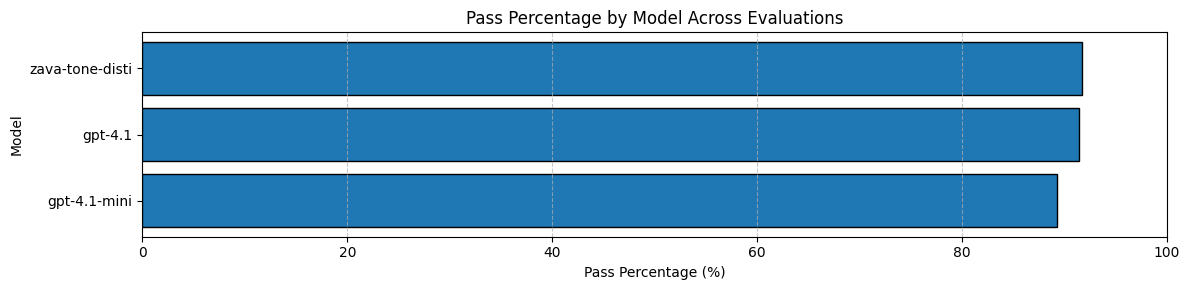

Fetching scores...

Score Summary Table:
          Model                         Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
zava-tone-disti zava-tone-posttrain-evaluation-b836c26f          3.75      1.00      4.00            4.00            4.00            4.00            4.00            4.00
        gpt-4.1 zava-tone-posttrain-evaluation-b836c26f          3.74      1.00      4.00            4.00            4.00            4.00            4.00            4.00
   gpt-4.1-mini zava-tone-posttrain-evaluation-b836c26f          3.68      1.00      4.00            1.00            4.00            4.00            4.00            4.00


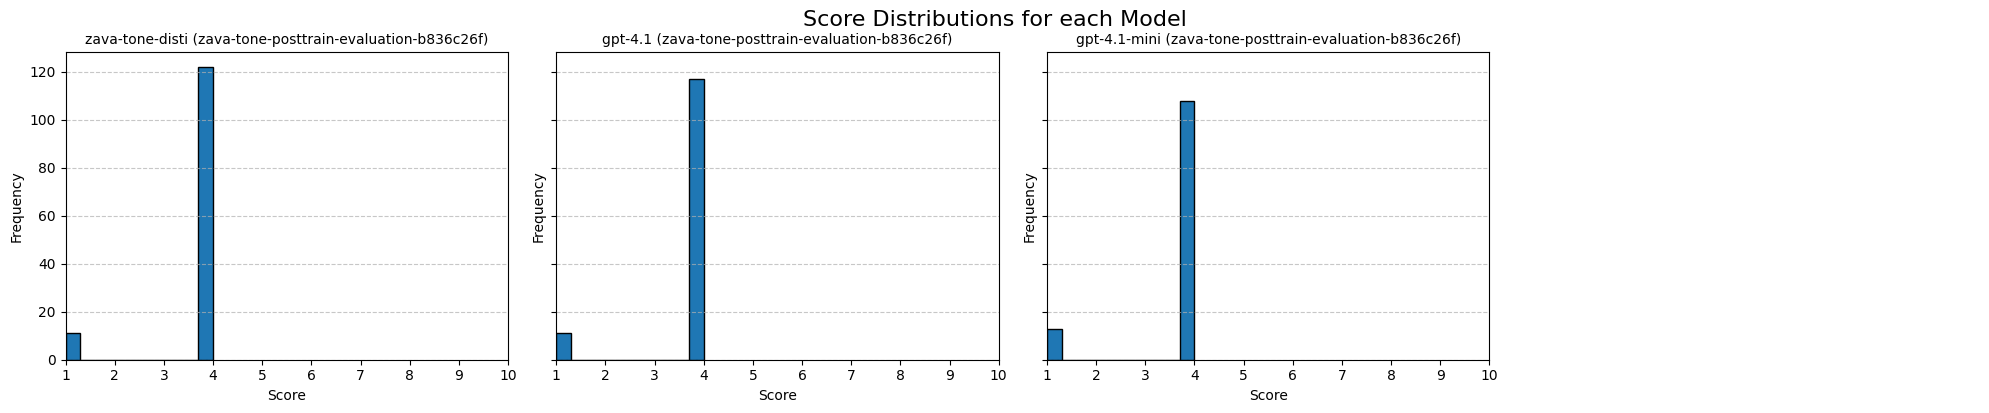

In [ ]:
# Let's visualize our post-training evaluation. Fingers crossed!
from eval_utils import display_evaluation_summary
display_evaluation_summary(client, [posttraining_eval.id], x_range=(1, 10))

Get Evaluation Runs: eval_68b6844dd6dc8191bf57777a7d74bf4f
Get Evaluation Runs: eval_68b6d9c91a4881918384d517abb81f0e

Combined Evaluation Summary
                                  Run ID                              Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                         Evaluation Name
evalrun_68b6849e001c81919d59824916b5c9a9                      o4-mini-b836c26f         o4-mini completed          100.000000             0.000000 eval_68b6844dd6dc8191bf57777a7d74bf4f             zava-tone-baseline-b836c26f
evalrun_68b6849d50648191b7498a255832c9db                           o3-b836c26f              o3 completed           98.571429            30.718954 eval_68b6844dd6dc8191bf57777a7d74bf4f             zava-tone-baseline-b836c26f
evalrun_68b6d9c9c9548191aa7972b9b40cb29c zava-tone-distilled-b836c26f-b836c26f zava-tone-disti completed           91.729323             0.000000 eval_68b6d9c91a4881918384d517abb81f

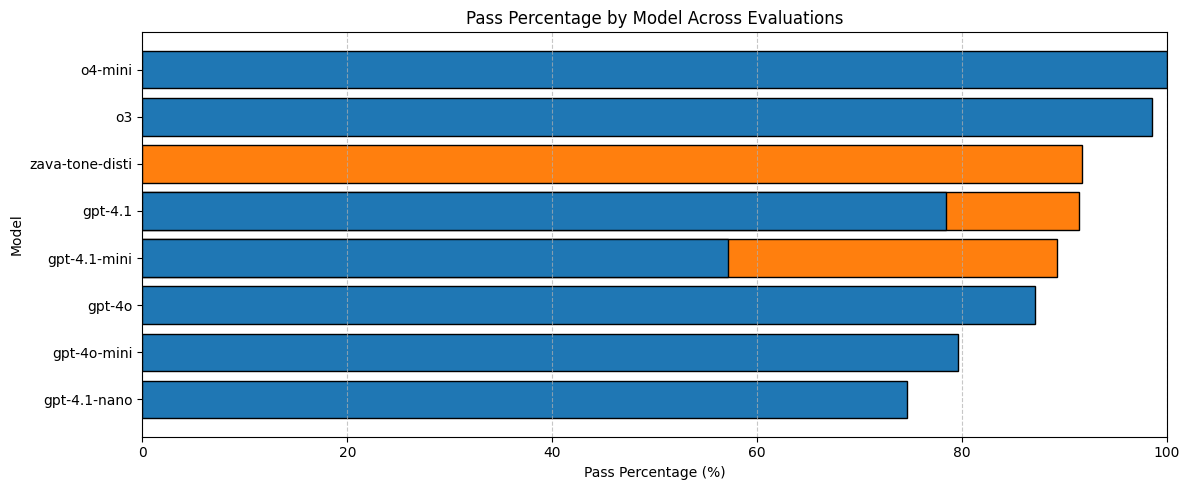

Fetching scores...

Score Summary Table:
          Model                         Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
             o3             zava-tone-baseline-b836c26f          7.69      1.00     10.00            4.00            8.00            8.00            9.00            9.00
        o4-mini             zava-tone-baseline-b836c26f          4.67      4.00      9.00            4.00            4.00            4.00            5.00            5.60
         gpt-4o             zava-tone-baseline-b836c26f          3.67      1.00      7.00            1.00            4.00            4.00            4.00            4.00
    gpt-4o-mini             zava-tone-baseline-b836c26f          3.59      1.00      9.00            1.00            4.00            4.00            4.00            4.00
        gpt-4.1             zava-tone-baseline-b836c26f          3.54      1.00      8.00            1.00    

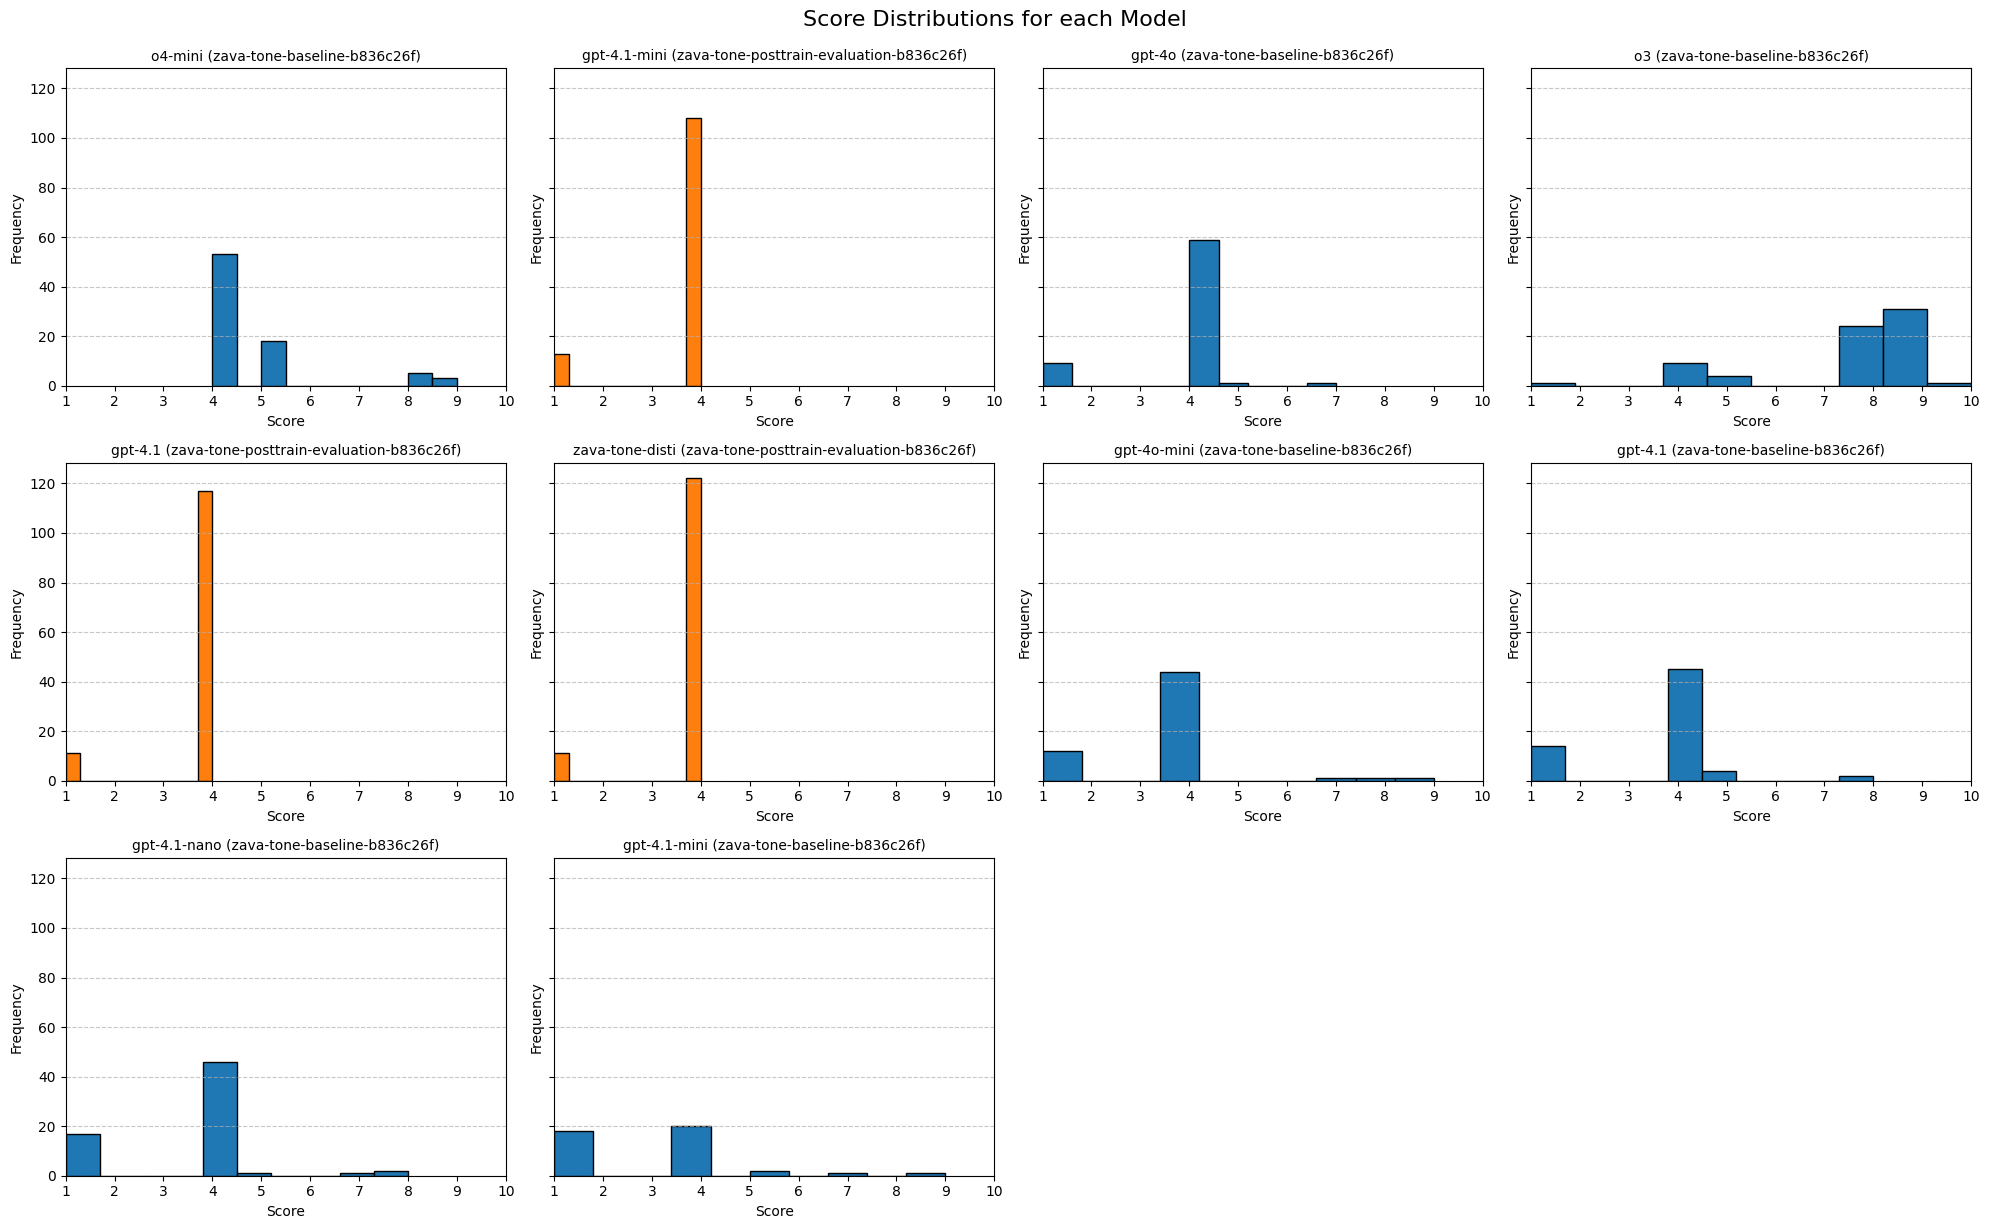

In [ ]:
# And now let's put it all together.
# Let's visualize our post-training evaluation. Fingers crossed!
display_evaluation_summary(client, [baseline_eval.id, posttraining_eval.id], x_range=(1, 10))

---

## 7. Teardown

Don't forget to clean up - delete the resource group, purge resources!

---

## 8. Summary 

In this notebook we demonstrated **distillation** using Azure OpenAI *Evaluations*
and *Fine Tuning* features.

We used an objective of *adjusting the tone* of a model to meet our needs, in this
case making its responses sarcastic, while preserving accuracy in results, and
*distilled* the native capabilities of a state-of-the-art reasoning model (`o3`)
into a much smaller, non-reasoning model (`4.1-nano`) to let our agent or app
use the smallest model possible while:

- 🤑 minimizing per-token costs
- 🏎️ improve performance (latency)

We did all this:

- without creating training data directly
- without knowing the ideal student model
- only by knowing how to define our Grader

So to wrap it all up:

1. We described the ideal state to our complex reasoning model in the form of
   a few samples we feel are ideal.
2. We described to the reasoning model (grader) how to judge those examples
   to measure their quality.
3. We let Evaluations and Fine Tuning do the rest!

### 🎯 Success Criteria:
- Function tests 4 different reasoning types
- Returns score 0.0-1.0 for generalization retention  
- Can identify when model only gives Zava hardware responses
- Uses ≤10 lines of core implementation logic

**Ready to code? Or need a hint about the approach?**